In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import RDConfig
import sys
import os
sys.path.append(os.path.join(RDConfig.RDContribDir, "SA_Score"))
import sascorer

In [3]:
def calculate_sas(smiles_string):
    """Calculates the SAS score for a given SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is not None:
            return sascorer.calculateScore(mol)
        return None
    except:
        return None

In [4]:
df = pd.read_csv('../data/lck_dockstring_data1.csv')

In [5]:
df['sas'] = df['smiles'].apply(calculate_sas)

In [7]:
df.head()

,Unnamed: 0,smiles,qed,tpsa,logp,sas,molwt,affinity
0,0,O=C1C(=O)C(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21,0.463229,124.29,1.39450,3.160078,302.238,-8.1
1,1,O=S(=O)(c1cccc2cnccc12)N1CCCNCC1,0.903457,62.30,1.21880,2.211947,291.376,-7.8
2,2,CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21,0.770003,29.54,3.05760,2.464484,249.335,-6.1
3,3,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,0.389416,86.28,4.59032,2.331660,493.615,-9.3
4,4,c1ccc2c(-c3ccncc3)c[nH]c2c1,0.632617,28.68,3.22990,1.819967,194.237,-6.8


In [8]:
df.columns

Index(['Unnamed: 0', 'smiles', 'qed', 'tpsa', 'logp', 'sas', 'molwt',
       'affinity'],
      dtype='object')

In [12]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qed'].values.reshape(-1,1))
logp_scaler.fit(df['logp'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsa'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qed'] = qed_scaler.transform(df['qed'].values.reshape(-1,1))
df['logp'] = logp_scaler.transform(df['logp'].values.reshape(-1,1))
df['tpsa'] = tpsas_scaler.transform(df['tpsa'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

In [ ]:
df.to_csv('../data/lck_dockstring_data.csv', index=False)

In [13]:
df

,qeds,logps,tpsas,affinity,smiles,split,sas
0,0.741053,0.587050,0.103017,0.469388,N=1C=C(C2=CC=C(C3=C(C=CC(C(=O)NC4CC4)=C3)C)C=C...,train,0.189236
1,0.301234,0.667379,0.058528,0.612245,P(=O)(NC(C1=CC=CC=C1)/C(=C/CCC)/CCC)(C2=CC=CC=...,train,0.316652
2,0.981270,0.509216,0.117940,0.520408,ClC=1C(C(=O)NC2=CC=C(C(=O)N3CCOCC3)C=C2)=CC=CC1,train,0.100876
3,0.465289,0.520187,0.123290,0.448980,O=C1N(C(=O)N(C=2C1=C(N3C2C(=NC4=C3C=CC=C4)C)C5...,train,0.223238
4,0.551182,0.569132,0.198753,0.408163,O=C(N1CCC(CC1)C(=O)NC=2C=C(CC(=O)NC3=CC=C(C(=O...,train,0.198249
...,...,...,...,...,...,...,...
260055,0.876207,0.517353,0.114220,0.642857,O1C=2C(OCC1)=CC=C(NC(=O)CCCOC3=CC=CC=C3)C2,test,0.114882
260056,0.668152,0.545802,0.081476,0.540816,N1(C=2C(=CC=C(C2)Cl)C(=C1)CCN(CCN3C(NCC3)=O)C)...,test,0.235550
260057,0.516460,0.517017,0.079043,0.489796,S\1C=2N(C=3C(N2)=CC=CC3)C(=O)/C1=C\C=4N(C5=CC=...,test,0.200821
260058,0.538643,0.588906,0.119107,0.561224,S1C(C(=O)N2CCCC=3C2=CC=CC3)=C(N)C=4C1=NC5=C(C4...,test,0.202804


In [15]:
SMI_MAX_SIZE= -1
with open('../data//smiles_corpus.txt', 'w') as f:
    train = []
    test = []        
    for i, row in df.iterrows():
        if row['split'] == "test":
            test.append(list(row.values))
        else:
            train.append(list(row.values))
        f.write(split(row['smiles'] +'\n'))
        
        if SMI_MAX_SIZE < len(row['smiles']):
            SMI_MAX_SIZE = len(row['smiles'])
f.close()
print("SMI_MAX_SIZE ", SMI_MAX_SIZE)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

SMI_MAX_SIZE  254


In [17]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

Building Vocab


In [18]:

class CustomTargetDataset(Dataset):
    def __init__(self, dataframe, SmilesVocab, properties_list):
        self.dataframe = dataframe
        self.smiles_vocab = SmilesVocab
        self.property_list = properties_list
        self.build()
        
    def build(self):
        smiles, properties, affinities= [],[],[]
        smiles_encoding = []
        for i, row in self.dataframe.iterrows():
            smi = row['smiles']
            # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
            newsmi = smi
            smiles.append(newsmi)
            smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
            props = []
            for p in self.property_list:
                props.append(row[p])
            properties.append(props)

        self.smiles_encodings = torch.tensor(smiles_encoding)
        self.properties = torch.tensor(properties)
        self.smiles = smiles
        # self.affinities = torch.tensor(affinities)
        print("dataset built")
        
    def __len__(self):
        return len(self.properties)
    
    def __getitem__(self, index):
        return {
            "smiles_rep": self.smiles_encodings[index],
            "properties": self.properties[index],
            "smiles":self.smiles[index]
        }

In [19]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

In [20]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

In [21]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

In [22]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))
        self.property_encoder = PropertyEncoder(d_model,n_properties=n_properties)
        
    def forward(self, x, property):
        property = self.property_encoder(property)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=property,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

In [23]:
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(data_loader):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)


In [24]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)
        

In [25]:
class Sampler:
    def __init__(self, model, vocab, temperature=1.0):
        self.model = model
        self.vocab = vocab
        self.temperature = temperature
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property) / self.temperature
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples
            

In [26]:
def sample_a_bunch(model, dataloader, greedy=False, temperature=1.0):
    sampler = Sampler(model, smiles_vocab, temperature=temperature)
    print("Temperature: ", temperature)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

In [27]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


In [28]:
config = {
    'batch_size' :512,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 1024,
    'lr': 1e-6,
    'epochs': 2,
    'properties': sorted(['affinity', 'qeds', 'logps','tpsas', 'sas'])
}
config['run_name'] = "LCK_DOCKSTRING_"+ "_".join(prop for prop in config['properties'])
print(config)

{'batch_size': 512, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 1024, 'lr': 1e-06, 'epochs': 2, 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'], 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'}


In [29]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [30]:
# train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=config['properties'])
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])

dataset built


In [32]:
# train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=2)

In [33]:
data =  next(iter(test_loader))
print(data.keys())

dict_keys(['smiles_rep', 'properties', 'smiles'])


In [34]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

In [35]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [36]:
config

{'batch_size': 512,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 6,
 'hidden_units': 1024,
 'lr': 1e-06,
 'epochs': 2,
 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'],
 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'}

In [ ]:
model = load_model(config)

No of GPUs available 2


FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas/model.pt'

: 

In [ ]:
# def sample_a_bunch(model, dataloader, greedy=False):
#     sampler = Sampler(model, smiles_vocab)
#     model.eval()
#     samples = []
#     properties = []
#     with torch.no_grad():
#         for i, data in enumerate(dataloader):
#             # data = {k: v.to(device) for k, v in data.items()}
#             smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
#             properties += data['properties'].cpu().numpy().tolist()
#             samples += smiles
#             print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
#             if len(samples) >= 1000:
#                 break
#     return np.array(properties), samples

In [ ]:
properties, samples, og_smiles = sample_a_bunch(model, test_loader, greedy=False, temperature=0.5)
train_SMILES = train_df['smiles'].tolist()
compute_metrics(train_SMILES, og_smiles, samples)

Temperature:  0.5


{'Validity': 0.9140625,
 'Novelty': 0.9882478632478633,
 'Uniqueness': 0.999465811965812}

In [ ]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [ ]:
print("validity rate", calculate_validity_rate(samples))

In [ ]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, samples)

In [ ]:
with open('../checkpoints/'+config['run_name'] +'/RawPreferenceData.pkl', 'rb') as f:
    new_target_smiles, new_target_properties, new_sampled_smiles = pickle.load(f)
    
new_sampled_smiles = np.array(new_sampled_smiles)
calculate_validity_rate(new_sampled_smiles[:,0])

0.0018660287081339712

In [ ]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_qeds = og_props[:,2]
og_sas = og_props[:,3]
og_tpsa = og_props[:,4]

In [ ]:
import seaborn as sns

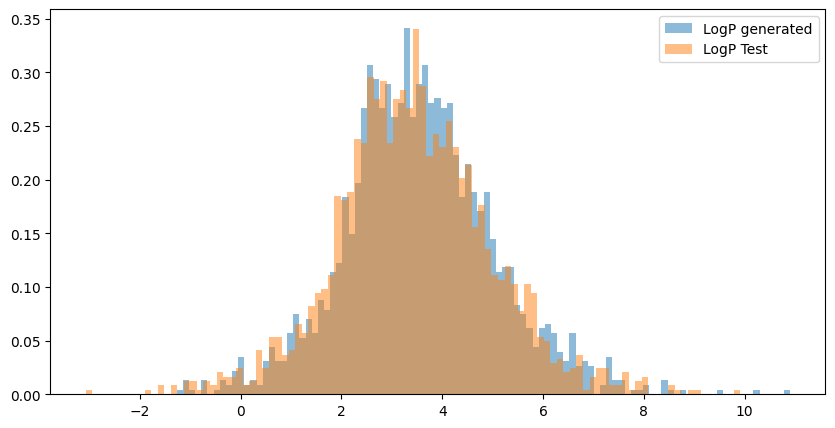

In [ ]:
#histogram density plot using matplotlib
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

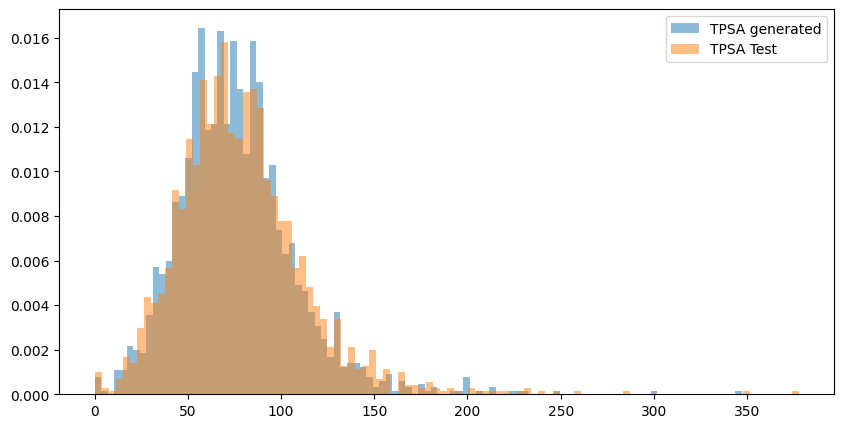

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

In [ ]:
stats = pd.DataFrame({
                      "SAS_pred":sas, 
                      "QED_pred":qeds, 
                      "LogP_pred":logps, 
                    #   "molwt_pred":molwt, 
                      "TPSA_pred":tpsas})
stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
stats['QED_og'] = qed_scaler.inverse_transform(og_qeds.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

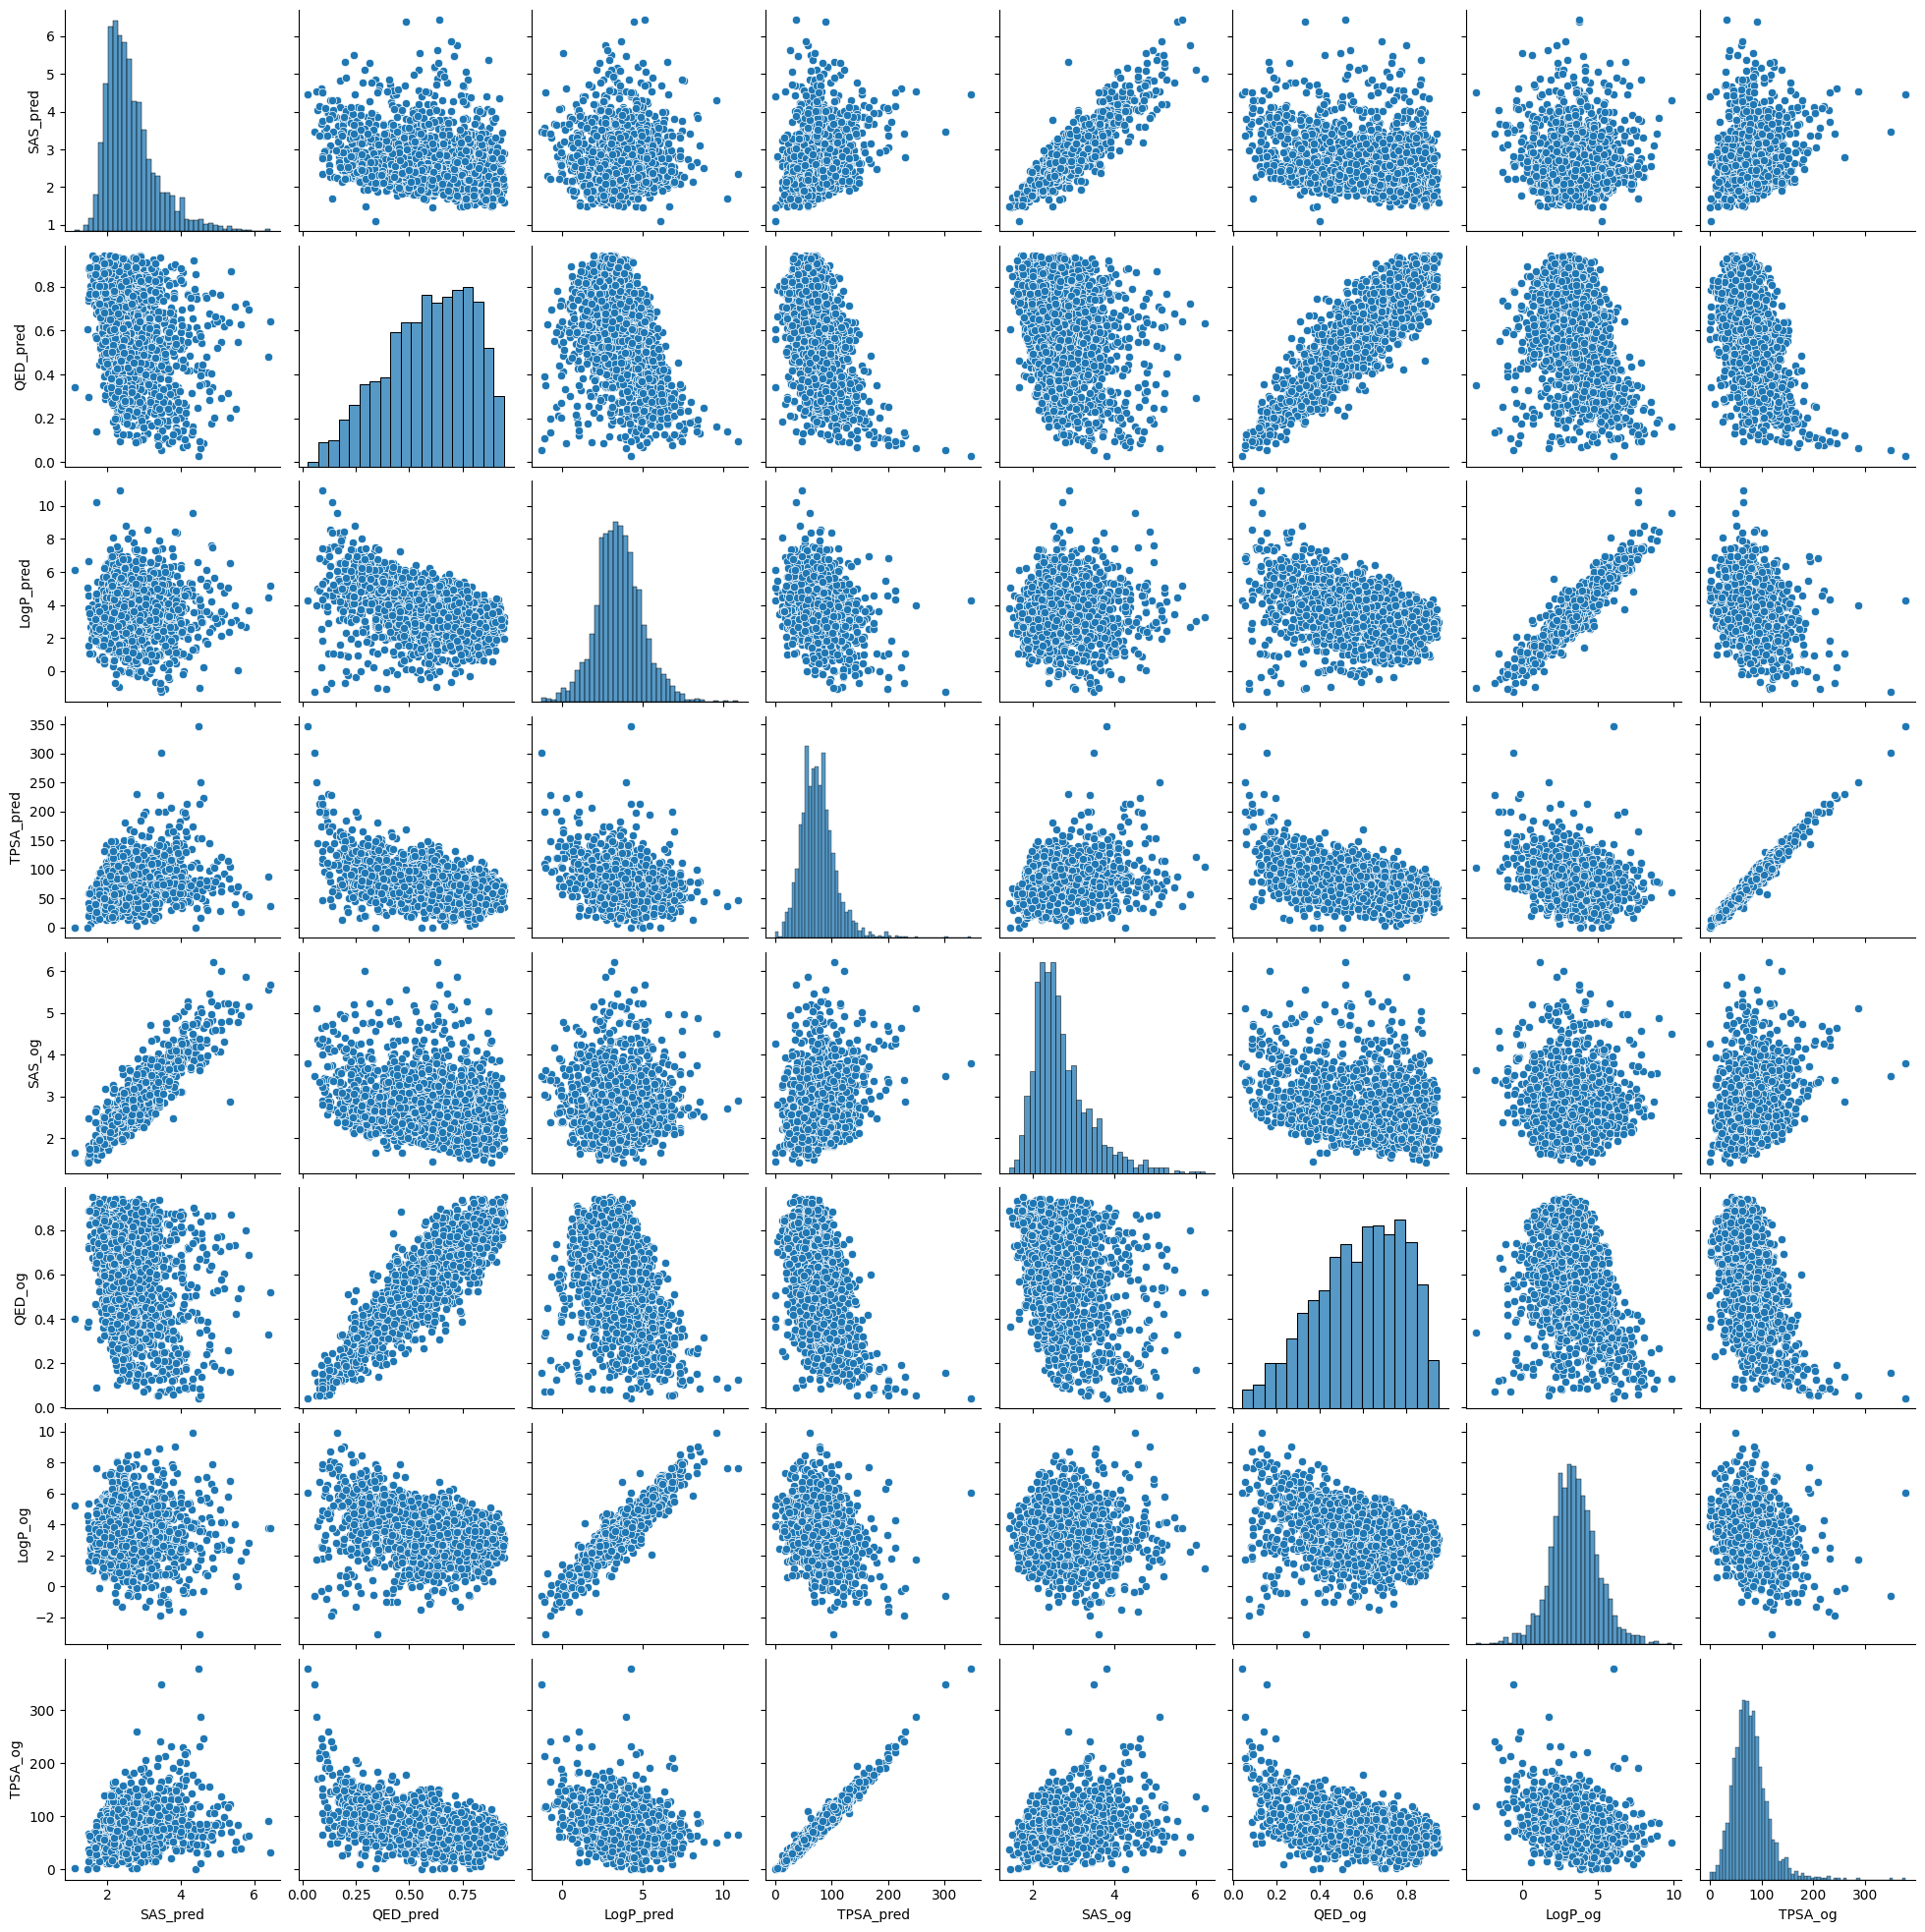

In [ ]:
sns.pairplot(stats)

In [ ]:
target_props = {}
target_props['affinity'] = [-9, -8, -7]
target_props['logp'] = [2, 5]
# target_props['molwt'] = [280, 320]
target_props['qed'] = [0.3, 0.8]
target_props['tpsa'] = [40,100]
target_props['sas'] = [2, 4]

In [ ]:
queries = []
property_vectors = []
for a in target_props['affinity']:
    for b in target_props['logp']:
        for c in target_props['qed']:
            for d in target_props['sas']:
                for e in target_props['tpsa']:
                    
                    key = str(a)+'-'+str(b)+'-'+str(c) + '-' + str(d) + '-' + str(e)
                    t = torch.Tensor([
                        affinity_scaler.transform([[a]]).flatten()[0],
                        logp_scaler.transform([[b]]).flatten()[0],
                        qed_scaler.transform([[c]]).flatten()[0],
                        sas_scaler.transform([[d]]).flatten()[0],
                        tpsas_scaler.transform([[e]]).flatten()[0]
                        ])
                    queries.append(key)
                    property_vectors.append(t)
property_vectors = torch.stack(property_vectors, dim=0)

In [ ]:
sampler = Sampler(model, smiles_vocab)

In [ ]:
results = {}
count = 0
for key, v in zip(queries, property_vectors):
    print(key, v)
    p = v.repeat(config['batch_size'], 1)
    samples = sampler.sample(p, greedy=False)
    if key in results:
        print("duplicate key", key)
    qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
    # results[key] = [logps, tpsas, qeds, samples]
    results[key] = [logps, qeds, sas, tpsas, samples]

    count += 1

-8-2-0.3-2-40 tensor([0.5714, 0.4638, 0.3106, 0.1468, 0.0805])


-8-2-0.3-2-100 tensor([0.5714, 0.4638, 0.3106, 0.1468, 0.2011])
-8-2-0.3-4-40 tensor([0.5714, 0.4638, 0.3106, 0.4405, 0.0805])
-8-2-0.3-4-100 tensor([0.5714, 0.4638, 0.3106, 0.4405, 0.2011])
-8-2-0.8-2-40 tensor([0.5714, 0.4638, 0.8424, 0.1468, 0.0805])
-8-2-0.8-2-100 tensor([0.5714, 0.4638, 0.8424, 0.1468, 0.2011])
-8-2-0.8-4-40 tensor([0.5714, 0.4638, 0.8424, 0.4405, 0.0805])
-8-2-0.8-4-100 tensor([0.5714, 0.4638, 0.8424, 0.4405, 0.2011])
-8-5-0.3-2-40 tensor([0.5714, 0.5918, 0.3106, 0.1468, 0.0805])
-8-5-0.3-2-100 tensor([0.5714, 0.5918, 0.3106, 0.1468, 0.2011])
-8-5-0.3-4-40 tensor([0.5714, 0.5918, 0.3106, 0.4405, 0.0805])
-8-5-0.3-4-100 tensor([0.5714, 0.5918, 0.3106, 0.4405, 0.2011])
-8-5-0.8-2-40 tensor([0.5714, 0.5918, 0.8424, 0.1468, 0.0805])
-8-5-0.8-2-100 tensor([0.5714, 0.5918, 0.8424, 0.1468, 0.2011])
-8-5-0.8-4-40 tensor([0.5714, 0.5918, 0.8424, 0.4405, 0.0805])
-8-5-0.8-4-100 tensor([0.5714, 0.5918, 0.8424, 0.4405, 0.2011])


In [ ]:
import pickle
import pandas as pd
# dump results dictionary into a pickle file

with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'wb') as f:
    pickle.dump(results, f)



In [ ]:
# with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'rb') as f:
    # results = pickle.load(f)

In [ ]:
# new_results = {}
# for i, key in enumerate(results):
#     print(i)
#     samples = results[key][3]
#     qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
#     new_results[key] = [logps, qeds, sas, tpsas, samples]
# with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'wb') as f:
#     pickle.dump(new_results, f)


In [ ]:
data = []
columns = ['Target LogP', 'Target QED', 'Target SAS', 'Target TPSA', 'Predicted LogP','Predicted QED' ,'Predicted SAS','Predicted TPSA', 'key']
for key in results:
    keys = key.split('-')
    affinity = keys[1]
    logp = keys[2]
    qed = keys[3]
    sas = keys[4]
    tpsa = keys[5]
    for i in range(len(results[key][0])):
        data.append([logp, qed, sas, tpsa, results[key][0][i], results[key][1][i], results[key][2][i], results[key][3][i], key])

In [ ]:
data_df = pd.DataFrame(data, columns=columns)

<AxesSubplot: xlabel='Predicted TPSA', ylabel='Density'>

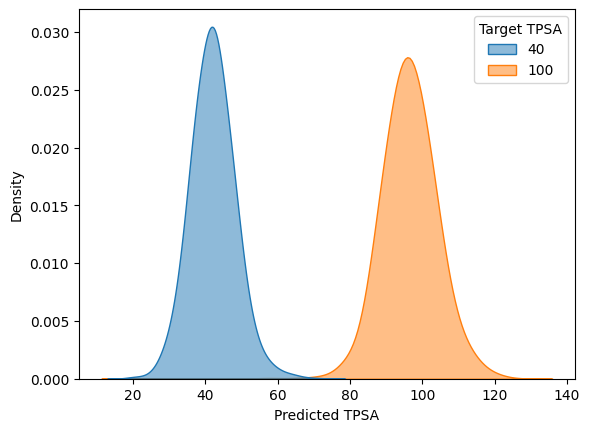

In [ ]:
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)

<AxesSubplot: xlabel='Predicted LogP', ylabel='Density'>

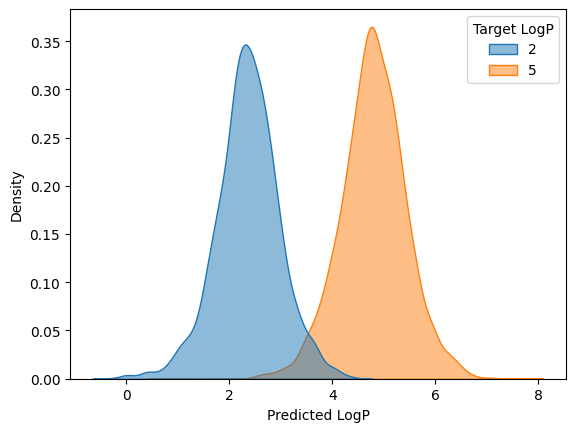

In [ ]:
sns.kdeplot(data=data_df, x="Predicted LogP",hue="Target LogP", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted QED', ylabel='Density'>

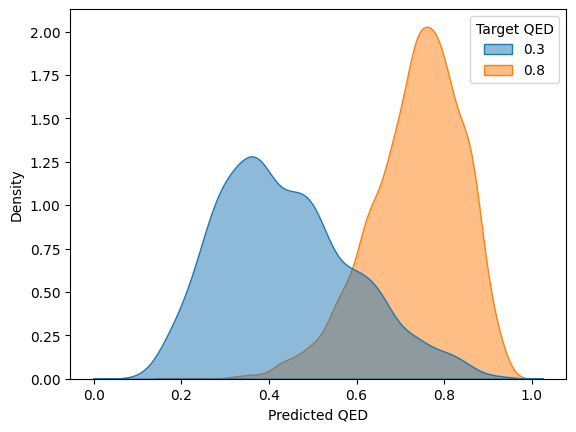

In [ ]:
sns.kdeplot(data=data_df, x="Predicted QED",hue="Target QED", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted SAS', ylabel='Density'>

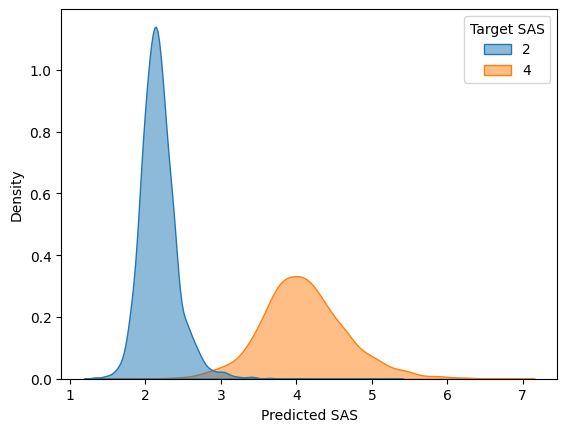

In [ ]:
sns.kdeplot(data=data_df, x="Predicted SAS",hue="Target SAS", fill=True,alpha=.5, linewidth=1)

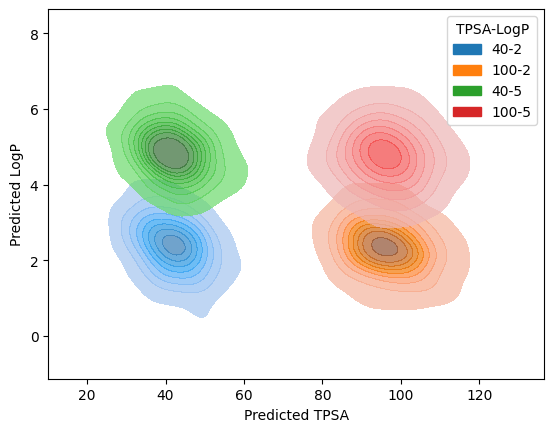

In [ ]:
data_df['TPSA-LogP'] = data_df['Target TPSA'] +'-' +data_df['Target LogP']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted LogP", hue="TPSA-LogP", fill=True, alpha=0.7, bw_adjust=1.5)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


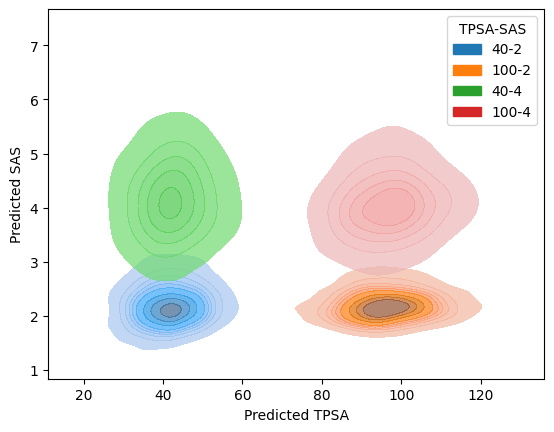

In [ ]:
data_df['TPSA-SAS'] = data_df['Target TPSA'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted SAS", hue="TPSA-SAS", fill=True, alpha=0.7, bw_adjust=1.5)

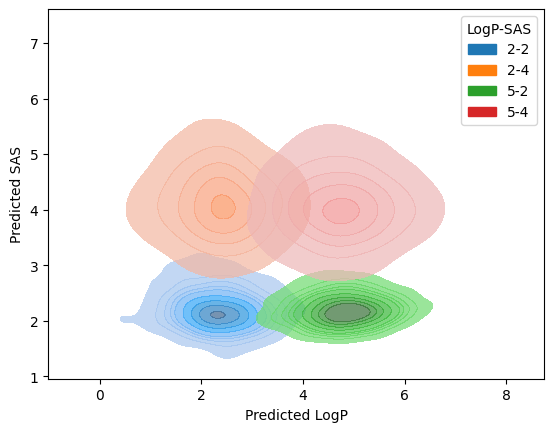

In [ ]:
data_df['LogP-SAS'] = data_df['Target LogP'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted LogP", y="Predicted SAS", hue="LogP-SAS", fill=True, alpha=0.7, bw_adjust=1.5)

In [ ]:
print(config)

In [ ]:
import pickle
import seaborn as sns
dist_data = pickle.load(open('../checkpoints/' + config['run_name'] + '/affinity_distribution.pkl', 'rb'))